In [44]:
import kagglehub
import os
import xml.etree.ElementTree as ET

import imutils
import cv2
import datetime
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

import pickle

# Load Data Functions

In [45]:
def download_dataset_path():
    # Download latest version
    path = kagglehub.dataset_download("andrewmvd/car-plate-detection")
    print("Path to dataset files:", path)
    return path

In [46]:
def get_relative_bbox(xml_path, height, width):
  tree = ET.parse(xml_path)
  root = tree.getroot()

  bbox = root.find('object').find('bndbox')
  xmin = int(bbox.find('xmin').text) / width
  ymin = int(bbox.find('ymin').text) / height
  xmax = int(bbox.find('xmax').text) / width
  ymax = int(bbox.find('ymax').text) / height

  return (xmin, ymin, xmax, ymax)

In [47]:
def load_data(path):
  print("Loading data...")
  image_names = os.listdir(os.path.join(path, "images"))
  annotation_names = os.listdir(os.path.join(path, "annotations"))

  image_names = sorted(image_names)
  annotation_names = sorted(annotation_names)

  print(f"Found {len(image_names)} images and {len(annotation_names)} annotations")

  n_images = len(image_names)
  data = []
  bboxes = []
  image_paths = []

  for img_name, ann_name in zip(image_names, annotation_names):
      img_path = os.path.join(path, "images", img_name)
      # Get width and height
      img = cv2.imread(img_path)
      (h, w) = img.shape[:2]

      img = load_img(img_path, target_size=(224, 224))
      img = img_to_array(img)

      ann_path = os.path.join(path, "annotations", ann_name)
      bbox = get_relative_bbox(ann_path, h, w)

      data.append(img)
      bboxes.append(bbox)
      image_paths.append(img_path)

  return data, bboxes, image_paths

# Load data

In [48]:
path = download_dataset_path()
data, bboxes, image_paths = load_data(path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1
Loading data...
Found 433 images and 433 annotations


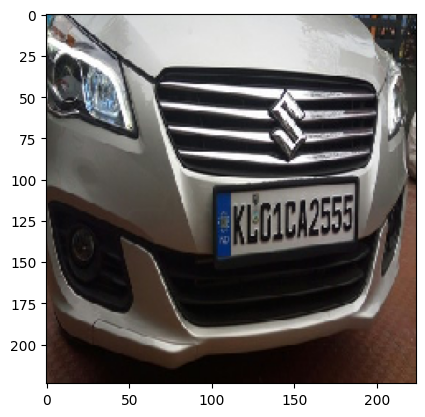

In [49]:
imgplot = plt.imshow(data[0].astype('uint8'))
plt.show()

# Normalize Data

In [50]:
# convert to numpy array
bboxes = np.array(bboxes, dtype="float32")
image_paths = np.array(image_paths)

# and convert data from range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0

# Split Data

In [51]:
(train_images, test_images, train_bboxes, test_bboxes, train_paths, test_paths) = train_test_split(
    data, bboxes, image_paths, test_size=0.20, random_state=42
)

# Setup and Train

In [52]:
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

# freeze all layers of VGG in order not to train them
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [53]:
# Create bounding box regression head
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

In [54]:
model = Model(
    inputs=vgg.input,
    outputs=bboxHead
)

In [55]:
# Set hyperparameters
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [56]:
# Compile the model
opt = Adam(INIT_LR)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["mae"])

In [57]:
# Train the model
print("Training bounding box regression model...")
H = model.fit(
    train_images, train_bboxes,
    validation_data=(test_images, test_bboxes),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1
)


Training bounding box regression model...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


11/11 ━━━━━━━━━━━━━━━━━━━━ 298s 27s/step - loss: 0.0405 - mae: 0.1532 - val_loss: 0.0179 - val_mae: 0.0992
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 315s 27s/step - loss: 0.0188 - mae: 0.1009 - val_loss: 0.0136 - val_mae: 0.0846
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 321s 27s/step - loss: 0.0116 - mae: 0.0775 - val_loss: 0.0116 - val_mae: 0.0773
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 323s 27s/step - loss: 0.0084 - mae: 0.0650 - val_loss: 0.0108 - val_mae: 0.0717
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 288s 27s/step - loss: 0.0060 - mae: 0.0530 - val_loss: 0.0105 - val_mae: 0.0698
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 288s 27s/step - loss: 0.0044 - mae: 0.0449 - val_loss: 0.0102 - val_mae: 0.0694
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 322s 27s/step - loss: 0.0036 - mae: 0.0392 - val_loss: 0.0098 - val_mae: 0.0656
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 322s 27s/step - loss: 0.0024 - mae: 0.0321 - val_loss: 0.0096 - val_mae: 0.0637
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 322s 27s/step - loss: 0.0023 

In [67]:
model.save('./model.keras')

# Train History

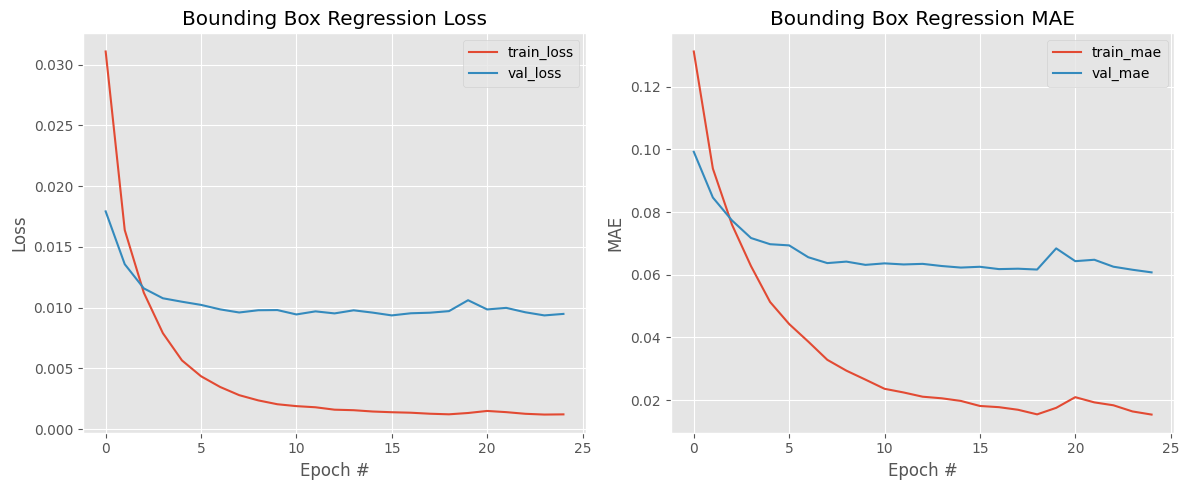

In [59]:
# Plot training history
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, NUM_EPOCHS), H.history["mae"], label="train_mae")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_mae"], label="val_mae")
plt.title("Bounding Box Regression MAE")
plt.xlabel("Epoch #")
plt.ylabel("MAE")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("bbox_training_plot.png")
plt.show()

# Test

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


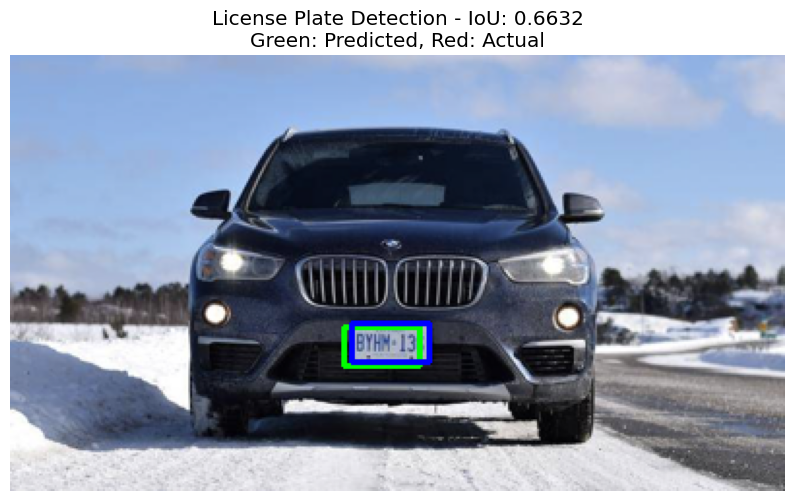

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


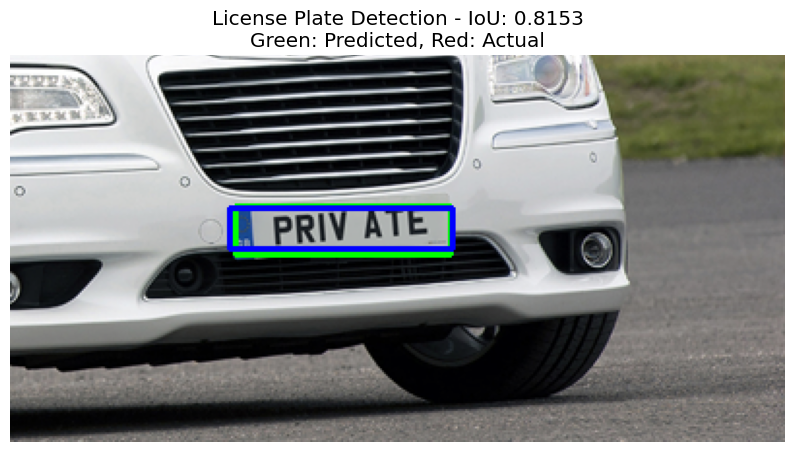

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


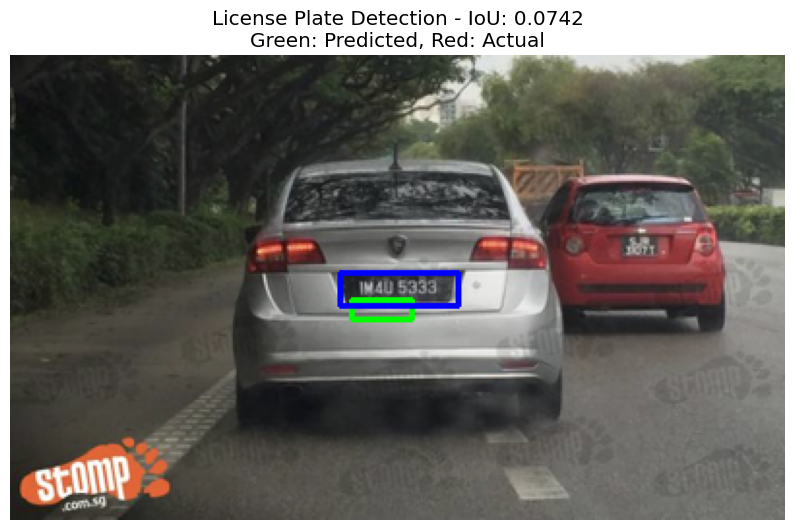

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


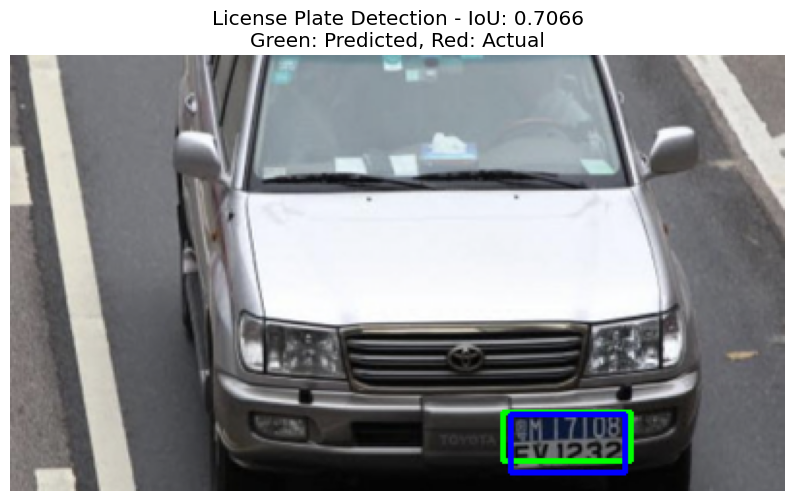

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


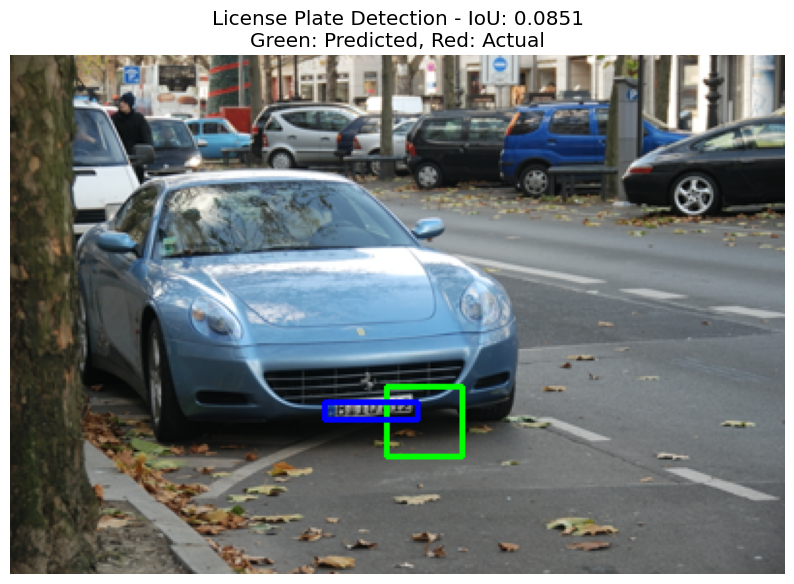

In [72]:
print("Evaluating model...")

num_test_samples = 5
test_indices = np.random.choice(len(test_paths), num_test_samples, replace=False)

for idx in test_indices:
    path = test_paths[idx]
    actual_bbox = test_bboxes[idx]

    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    boxPreds = model.predict(image)[0]
    (startX, startY, endX, endY) = boxPreds

    orig_image = cv2.imread(path)
    (h, w) = orig_image.shape[:2]

    # Scale up coordinates
    pred_startX = int(startX * w)
    pred_startY = int(startY * h)
    pred_endX = int(endX * w)
    pred_endY = int(endY * h)
    actual_startX = int(actual_bbox[0] * w)
    actual_startY = int(actual_bbox[1] * h)
    actual_endX = int(actual_bbox[2] * w)
    actual_endY = int(actual_bbox[3] * h)

    # Draw
    cv2.rectangle(orig_image,
                  (pred_startX, pred_startY),
                  (pred_endX, pred_endY),
                  (0, 255, 0),
                  2)

    cv2.rectangle(orig_image,
                 (actual_startX, actual_startY),
                 (actual_endX, actual_endY),
                 (255, 0, 0),
                 2)

    # Calculate IoU
    inter_x1 = max(pred_startX, actual_startX)
    inter_y1 = max(pred_startY, actual_startY)
    inter_x2 = min(pred_endX, actual_endX)
    inter_y2 = min(pred_endY, actual_endY)

    # Calculate intersection
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Calculate union
    pred_area = (pred_endX - pred_startX) * (pred_endY - pred_startY)
    actual_area = (actual_endX - actual_startX) * (actual_endY - actual_startY)
    union_area = pred_area + actual_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0

    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.title(f"License Plate Detection - IoU: {iou:.4f}\nGreen: Predicted, Red: Actual")
    plt.axis("off")
    plt.show()